Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline

from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set_style('ticks')
sns.set_context('talk')
sns.set_palette('dark')

In [2]:
filepath='flats_moscow.csv'
data=pd.read_csv(filepath,sep=',')

In [3]:
data.head()

,Unnamed: 0,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
0,1,81,58,40,6.0,12.5,7,1,1,1,3
1,2,75,44,28,6.0,13.5,7,1,0,1,6
2,3,128,70,42,6.0,14.5,3,1,1,1,3
3,4,95,61,37,6.0,13.5,7,1,0,1,1
4,5,330,104,60,11.0,10.5,7,0,1,1,3


Attribute target variable and features

In [4]:
X=data.drop(['Unnamed: 0','price','code'],axis=1)
y=data[['price']]

In [5]:
y.head()

,price
0,81
1,75
2,128
3,95
4,330


In [6]:
y.rename({'price':'Price in 1000 USD'},axis=1)

,Price in 1000 USD
0,81
1,75
2,128
3,95
4,330
...,...
2035,110
2036,95
2037,95
2038,129


Now, I would like to implement Cross-Validation and tune hyperparameters for different regression models

In [7]:
alphas = np.geomspace(1e-3, 1e0, num=8)
alphas

array([0.001     , 0.0026827 , 0.00719686, 0.01930698, 0.05179475,
       0.13894955, 0.37275937, 1.        ])

In [8]:
kf=KFold(shuffle=True,random_state=72018, n_splits=4)
lr=LinearRegression()
s=MinMaxScaler()
pf2=PolynomialFeatures(degree=2)
pf3=PolynomialFeatures(degree=3)
#X_pf=pf.fit_transform(X)

In [9]:
scores = []
coefs = []
for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)
    estimator=Pipeline([('scaler',s), ('polynom_transform',pf2),('lasso',las)])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    
    score = r2_score(y, predictions)

    scores.append(score)

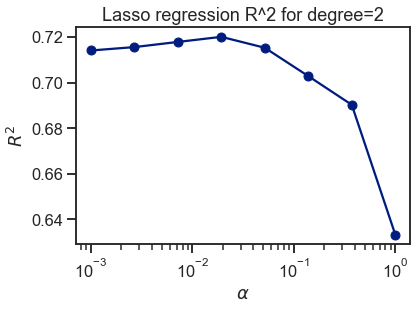

In [10]:
plt.semilogx(alphas,scores,marker='o')
plt.title('Lasso regression R^2 for degree=2')
plt.ylabel('$R^2$')
plt.xlabel('$\\alpha$')
plt.savefig('Lasso_optimization.jpg')

In [11]:
#i,score =max(scores)
(max_v,max_i) = max((score,i) for i,score in enumerate(scores))
best_alpha=alphas[max_i]

In [12]:
# Then release it into the wild .....
best_estimator = Pipeline([
                    ("scaler", s),
                    ("make_higher_degree", PolynomialFeatures(degree=2)),
                    ("lasso_regression", Lasso(alpha=best_alpha))])

best_estimator.fit(X, y)
print('Best R^2 score found with lasso regression is',best_estimator.score(X, y))
print('Best alpha value in this case is',round(best_alpha,4))

Best R^2 score found with lasso regression is 0.7400322573273883
Best alpha value in this case is 0.0193


In [13]:
scores = []
coefs = []
alphas=np.geomspace(0.001,1,20)
for alpha in alphas:
    r = Ridge(alpha=alpha, max_iter=100000)
    estimator=Pipeline([('scaler',s), ('polynom_transform',pf2),('ridge',r)])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    
    score = r2_score(y, predictions)

    scores.append(score)

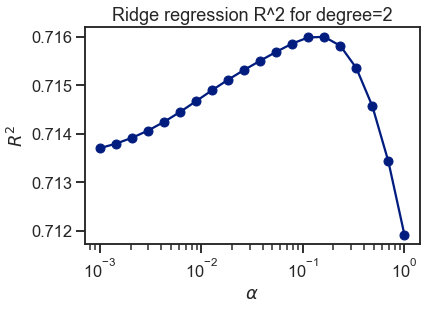

In [14]:
plt.semilogx(alphas,scores,marker='o')
plt.title('Ridge regression R^2 for degree=2')
plt.ylabel('$R^2$')
plt.xlabel('$\\alpha$')
plt.savefig('Ridge_regression_optimization.jpg')

In [15]:
(max_v,max_i) = max((score,i) for i,score in enumerate(scores))
best_alpha=alphas[max_i]
print('Best_alpha_for_Ridge is {}'.format(best_alpha))

Best_alpha_for_Ridge is 0.1623776739188721


### Now I learn how to find best Lasso hyperparameters, I will use
### linear regression, polynomial regression with degree 2, polynomial regression with degree 3, and lasso with degree 2, ridge with degree 2

array([[<AxesSubplot:title={'center':'price'}>]], dtype=object)

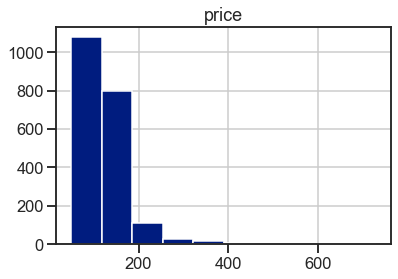

In [16]:
y.hist()

I will transform the price collumn with boxcox

## 1) Linear regression study

In [17]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)
X_ss_train=s.fit_transform(X_train)
lr.fit(X_ss_train,y_train)
y_fit=lr.predict(X_ss_train)
X_ss_test=s.transform(X_test)
y_pred=lr.predict(X_ss_test)
#print('Train Linear Regression R^2 is',r2_score(y_fit,y_train))
print('Test Linear Regression R^2 is',r2_score(y_pred,y_test))
#print('Train Mean_squared_error is',mean_squared_error(y_fit,y_train))
print('Test Mean_squared_error is',mean_squared_error(y_pred,y_test))

Test Linear Regression R^2 is 0.378642915380613
Test Mean_squared_error is 1017.5217924580708


This model is far from being perfect

See the boxcox transformation

(array([  2.,   0.,   1.,  49., 231., 356., 369., 283., 106.,  31.]),
 array([0.99920481, 1.00120209, 1.00319937, 1.00519665, 1.00719393,
        1.00919121, 1.01118849, 1.01318577, 1.01518304, 1.01718032,
        1.0191776 ]),
 <BarContainer object of 10 artists>)

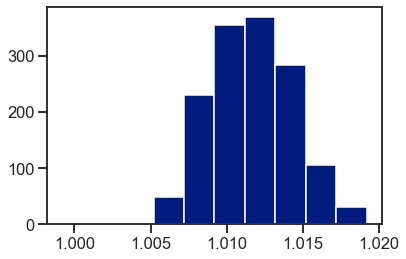

In [18]:
#I check the error with boxcox
bc1=boxcox(y_train.iloc[:,0])
y_train_bc=bc1[0]
lam=bc1[1]
plt.hist(y_train_bc)

In [19]:
'''lr2=LinearRegression()
X_ss_train=s.fit_transform(X_train)
lr2.fit(X_ss_train,y_train_bc)
X_ss_test=s.transform(X_test)
y_pred_bc=lr2.predict(X_ss_test)
#print(inv_boxcox(y_pred_bc,lam))
#print(y_test)
y_pred_1=inv_boxcox(y_pred_bc,lam)
y_pred_1 = np.where(np.isnan(y_pred_1), 0, y_pred_1) 
print('Test Linear Regression R^2 [boxcox] is',r2_score(y_pred_1,y_test))
print('Test Mean_squared_error [boxcox] is',mean_squared_error(y_pred_1,y_test))
print(y_pred_1)'''
pass

In [20]:
lr_r2=r2_score(y_pred,y_test)
lr_mse=mean_squared_error(y_pred,y_test)

In [21]:
params={'Model':[],'R^2':[],'Mean Sq Error':[]}

In [22]:
params['Model'].append('Linear Regression')
params['R^2'].append(lr_r2)
params['Mean Sq Error'].append(lr_mse)

## 2) Polynomial features (degree=2)

In [23]:
def polynom_fit_predict(X,y,degree=2,rand_state=42):
    pf=PolynomialFeatures(degree=degree)
    X_pf=pf.fit_transform(X)
    X_train, X_test, y_train, y_test=train_test_split(X_pf, y, test_size=0.3, random_state=rand_state)
    X_ss_train=s.fit_transform(X_train)
    lr.fit(X_ss_train,y_train)
    X_ss_test=s.transform(X_test)
    y_pred=lr.predict(X_ss_test)
    print('Test Polynom deg={} Regression\n R^2 is'.format(degree),round(r2_score(y_pred,y_test),3))
    print('Test Polynom deg={} Regression\n Mean_squared_error is'.format(degree),mean_squared_error(y_pred,y_test))
    return (r2_score(y_pred,y_test),mean_squared_error(y_pred,y_test))

In [24]:
poly2_params=polynom_fit_predict(X,y,degree=2)

Test Polynom deg=2 Regression
 R^2 is 0.561
Test Polynom deg=2 Regression
 Mean_squared_error is 811.1030832075853


R^2 gets much better, we reduce bias

In [25]:
params['Model'].append('Poly 2')
params['R^2'].append(poly2_params[0])
params['Mean Sq Error'].append(poly2_params[1])

## 3) Polynomial features (degree=3)

In [26]:
poly3_params=polynom_fit_predict(X,y,degree=3)

Test Polynom deg=3 Regression
 R^2 is 0.301
Test Polynom deg=3 Regression
 Mean_squared_error is 1971.2249632018484


R^2 becomes too high, we increse variance substantially

In [27]:
params['Model'].append('Poly 3')
params['R^2'].append(poly3_params[0])
params['Mean Sq Error'].append(poly3_params[1])

## 4)Lasso (degree=2)

In [28]:
from sklearn.linear_model import LassoCV
pf=PolynomialFeatures(degree=2)
X_pf=pf.fit_transform(X)

X_train, X_test, y_train, y_test=train_test_split(X_pf, y.iloc[:,0], test_size=0.3, random_state=42)
alphas2 = np.geomspace(0.002, 2, 20)

lassoCV = LassoCV(alphas=alphas2,
                  max_iter=5e4,
                  cv=4).fit(X_train, y_train)
y_lasso_pred=lassoCV.predict(X_test)
lassoCV_r2 = r2_score(y_test,y_lasso_pred)
lassoCV_mse = mean_squared_error(y_test,y_lasso_pred)
print('Test Polynom deg=2 + Lasso Regression\n R^2 is', round(lassoCV_r2,3))
print('Test Polynom deg=2 + Lasso Regression\n Mean_squared_error is',round(lassoCV_mse,0))

Test Polynom deg=2 + Lasso Regression
 R^2 is 0.726
Test Polynom deg=2 + Lasso Regression
 Mean_squared_error is 811.0


In [29]:
print('Alpha coefficient for Lasso regression is {}.'.format(lassoCV.alpha_))

Alpha coefficient for Lasso regression is 0.05273301797460717.


In [30]:
params['Model'].append('Poly2+Lasso')
params['R^2'].append(lassoCV_r2)
params['Mean Sq Error'].append(lassoCV_mse)

## 5) Ridge (degree=2)

In [31]:
from sklearn.linear_model import RidgeCV
alphas3=np.geomspace(0.001,1,20)
rCV = RidgeCV(alphas=alphas3,
                  cv=4).fit(X_train, y_train)
y_ridge_pred=rCV.predict(X_test)
rCV_r2 = r2_score(y_test,y_ridge_pred)
rCV_mse = mean_squared_error(y_test,y_ridge_pred)
print('Test Polynom deg=2 + Ridge Regression\n R^2 is', round(rCV_r2,3))
print('Test Polynom deg=2 + Ridge Regression\n Mean_squared_error is',round(rCV_mse,0))
print('Alpha coefficient for Ridge regression is {}.'.format(rCV.alpha_))

Test Polynom deg=2 + Ridge Regression
 R^2 is 0.727
Test Polynom deg=2 + Ridge Regression
 Mean_squared_error is 810.0
Alpha coefficient for Ridge regression is 1.0.


In [32]:
params['Model'].append('Poly2+Ridge')
params['R^2'].append(rCV_r2)
params['Mean Sq Error'].append(rCV_mse)

In [33]:
Model_accuracies=pd.DataFrame(params)

In [34]:
Model_accuracies.set_index('Model')

,R^2,Mean Sq Error
Model,,
Linear Regression,0.378643,1017.521792
Poly 2,0.560966,811.103083
Poly 3,0.301289,1971.224963
Poly2+Lasso,0.726387,811.333751
Poly2+Ridge,0.726969,809.606983


Finally, the analysis is finished.

I found that Ridge model performs the best.
I will plot Ridge predicted test values versus real test values

In [65]:
def make_plot(y_test,y_pred,model):
    sns.set_style('ticks')
    sns.set_context('talk')
    sns.set_palette('bright')

    ax = plt.axes()
    ax.set_xlim([0,600])
    ax.set_ylim([0,600])
    ax.plot(y_test, y_pred, ls='', marker='o')
    ax.set(title=model, xlabel='Real prices (1000 $)', ylabel='Predicted prices (1000 $)')

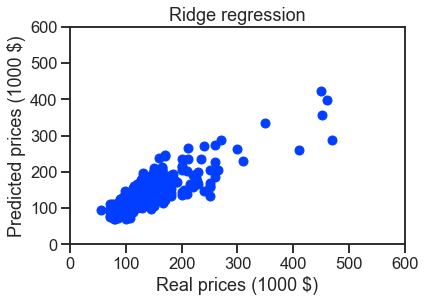

In [66]:
make_plot(y_test,y_ridge_pred,'Ridge regression')

In [37]:
pf.get_feature_names(X.columns)

['1',
 'totsp',
 'livesp',
 'kitsp',
 'dist',
 'metrdist',
 'walk',
 'brick',
 'floor',
 'totsp^2',
 'totsp livesp',
 'totsp kitsp',
 'totsp dist',
 'totsp metrdist',
 'totsp walk',
 'totsp brick',
 'totsp floor',
 'livesp^2',
 'livesp kitsp',
 'livesp dist',
 'livesp metrdist',
 'livesp walk',
 'livesp brick',
 'livesp floor',
 'kitsp^2',
 'kitsp dist',
 'kitsp metrdist',
 'kitsp walk',
 'kitsp brick',
 'kitsp floor',
 'dist^2',
 'dist metrdist',
 'dist walk',
 'dist brick',
 'dist floor',
 'metrdist^2',
 'metrdist walk',
 'metrdist brick',
 'metrdist floor',
 'walk^2',
 'walk brick',
 'walk floor',
 'brick^2',
 'brick floor',
 'floor^2']

In [70]:

df_importances=pd.DataFrame(zip(pf.get_feature_names(X.columns), rCV.coef_)).sort_values(by=1)
df_importances.rename({0:'Poly features',1:'Coefficient'},axis=1)
df_importances.head().to_excel('Most_negative_parameters.xlsx')
df_importances.tail().to_excel('Most positive parameters.xlsx')

### Just I will play around
Check how I predict the first value

In [39]:
X.loc[[0]]

,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor
0,58,40,6.0,12.5,7,1,1,1


In [40]:
y.loc[[0]]

,price
0,81


In [41]:
X_pf_1=pf.transform(X.loc[[0]])

In [42]:
y_ridge_1=rCV.predict(X_pf_1)
y_ridge_1

array([104.63987747])

Now I will make my input to predict price

In [43]:
my_x_values=pd.DataFrame([75, 15, 6, 10, 10, 0, 0, 1]).T
my_x_values

,0,1,2,3,4,5,6,7
0,75,15,6,10,10,0,0,1


In [44]:
#Predict price from my own input values
X_pf_2=pf.transform(my_x_values)
y_ridge_2=rCV.predict(X_pf_2)
y_ridge_2

array([201.55191756])